In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats


In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 

In [3]:
df = pd.read_csv('../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])

**Table of contents**<a id='toc0_'></a>    
- [EDA](#toc1_)    
  - [Summary statistics](#toc1_1_)    
  - [Distribution](#toc1_2_)    
  - [Histrograms for distributions](#toc1_3_)    
- [Preprocessing](#toc2_)    
  - [Sliding window time series](#toc2_1_)    
- [Transformation](#toc3_)    
  - [Determining optimal lag features](#toc3_1_)    
  - [Adding optimal (15x weekly) lag features](#toc3_2_)    
  - [Encoding categorical data](#toc3_3_)    
  - [Log-transforming skewed volume data](#toc3_4_)    
  - [Normalizing to scale numerical features](#toc3_5_)    
- [Feature Extraction](#toc4_)    
- [Feature Selection](#toc5_)    
  - [Correlation Matrix](#toc5_1_)    
  - [Filter, wrapper, and embedded](#toc5_2_)    
  - [Interpretation and integration into the df](#toc5_3_)    
  - [Correlation matrix before/after feature selection](#toc5_4_)    
- [Ferdig med feature extraction og selection!](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[EDA](#toc0_)

## <a id='toc1_1_'></a>[Summary statistics](#toc0_)

In [4]:
df.head()
# latex_table = tabulate(df.head(), headers='keys', tablefmt='latex')
# print(latex_table)

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,104.77,106.00,104.68,105.79,70221808,0
1,2005-02-28,105.55,105.68,104.56,105.08,79695344,0
2,2005-03-01,105.22,105.87,105.22,105.62,54607412,0
3,2005-03-02,105.21,106.22,105.10,105.57,73733090,0
4,2005-03-03,105.99,106.20,105.15,105.61,71286823,0


In [5]:
df.describe()
# latex_table = tabulate(df.describe(), headers='keys', tablefmt='latex', floatfmt=".2f")
# print(latex_table)

,Date,Open,High,Low,Close,Volume,OpenInt
count,3201,3201.00,3201.00,3201.00,3201.00,3201.00,3201.00
mean,2011-07-05 17:50:12.933458432,141.26,142.01,140.44,141.28,168053377.03,0.00
min,2005-02-25 00:00:00,59.20,60.98,58.45,59.33,17528276.00,0.00
25%,2008-05-01 00:00:00,107.81,108.38,107.01,107.72,85233525.00,0.00
50%,2011-07-06 00:00:00,123.61,124.25,122.73,123.55,133631300.00,0.00
75%,2014-09-10 00:00:00,183.68,184.87,182.45,183.70,213165418.00,0.00
max,2017-11-10 00:00:00,258.97,259.35,258.22,259.11,1000439720.00,0.00
std,NaN,46.51,46.49,46.54,46.53,118091256.06,0.00


In [6]:
df.info()
# latex_table = tabulate(df.info(), headers='keys', tablefmt='latex')
# print(latex_table)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     3201 non-null   datetime64[ns]
 1   Open     3201 non-null   float64       
 2   High     3201 non-null   float64       
 3   Low      3201 non-null   float64       
 4   Close    3201 non-null   float64       
 5   Volume   3201 non-null   int64         
 6   OpenInt  3201 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 175.2 KB


In [7]:
df.isnull().sum()
# null_counts = df.isnull().sum().reset_index()
# null_counts.columns = ['Column', 'Null Count']
# latex_table = tabulate(null_counts, headers='keys', tablefmt='latex')
# print(latex_table)

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [8]:
df.duplicated().sum()
# duplicate_count = df.duplicated().sum()
# duplicate_summary = pd.DataFrame({
#     'Description': ['Total Duplicate Rows'],
#     'Count': [duplicate_count]
# })
# latex_table = tabulate(duplicate_summary, headers='keys', tablefmt='latex', showindex=False)
# print(latex_table)


np.int64(0)

## <a id='toc1_2_'></a>[Distribution](#toc0_)
<a name="Distribution"></a>

In [9]:
# candle chart 

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'])

# Create a copy of the DataFrame for the last month
df_copy = df.copy(deep=True)
df_copy = df_copy[df_copy['Date'] > df_copy['Date'].max() - pd.DateOffset(months=1)]

# Create subplots with individual row heights
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=(
                        'S&P 500 (SPY) Price Chart 25. february 2005 to 10. november 2017', 
                        'S&P 500 (SPY) Price Chart, 11. november 2017 to 10. november 2017'),
                    vertical_spacing=0.15,
                    row_heights=[0.7, 0.3])  # Adjust the heights as needed

# Add the first candlestick chart (entire data)
fig.add_trace(go.Candlestick(
    x=df['Date'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name=''  # Set the name to an empty string
), row=1, col=1)

# Add the second candlestick chart (last month)
fig.add_trace(go.Candlestick(
    x=df_copy['Date'],
    open=df_copy['Open'],
    high=df_copy['High'],
    low=df_copy['Low'],
    close=df_copy['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name=''  # Set the name to an empty string
), row=2, col=1)

# Update layout settings
fig.update_layout(
    title='S&P 500 (SPY) Price Charts',
    xaxis_title='Date',
    yaxis_title='Price features',
    xaxis_rangeslider_visible=False,  # Disable range slider for the first x-axis
    height=1000,  # Overall height for the entire figure
    showlegend=False  # Hide the legend
)

# Disable range slider for the second x-axis
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)

# Optionally, adjust the y-axes for each subplot
fig.update_yaxes(title_text='Price features', row=1, col=1)
fig.update_yaxes(title_text='Price features', row=2, col=1)

# Show the plot
fig.show()


## <a id='toc1_3_'></a>[Histrograms for distributions](#toc0_)

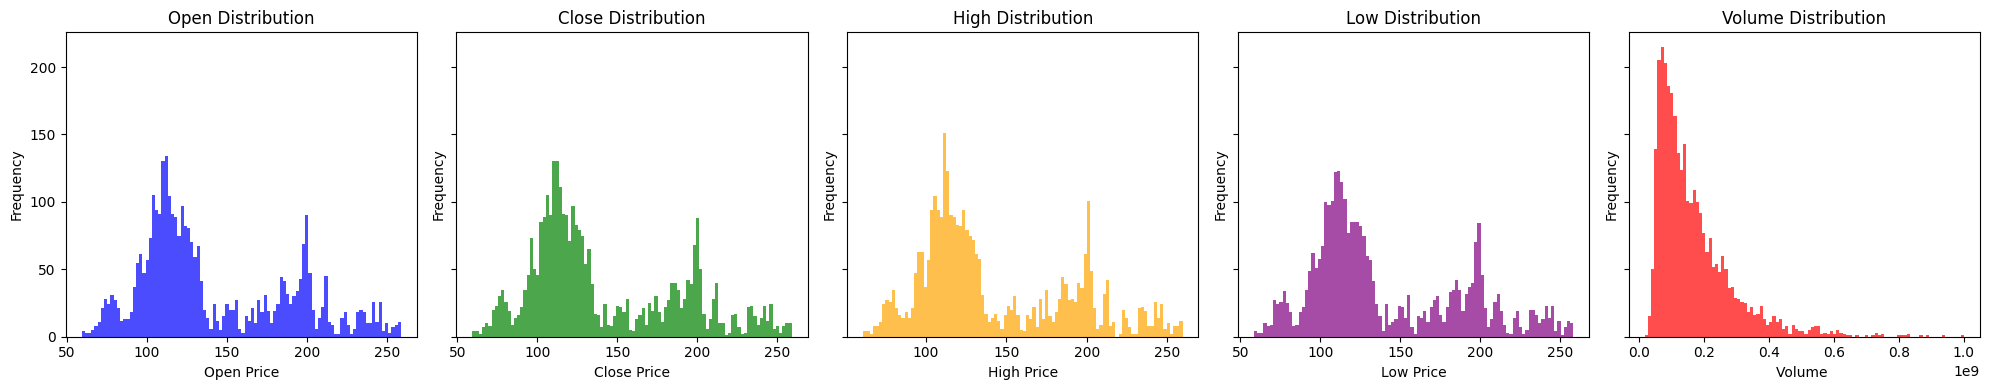

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'Open', 'Close', 'High', 'Low', and 'Volume' columns

# Set up a figure with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Define column names and colors for easy iteration
columns = ['Open', 'Close', 'High', 'Low', 'Volume']
colors = ['blue', 'green', 'orange', 'purple', 'red']

# Plot a histogram for each column
for i, column in enumerate(columns):
    axes[i].hist(df[column], bins=100, color=colors[i], alpha=0.7)
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xlabel(f'{column} {"Price" if column != "Volume" else ""}')  # Set x-axis label
    axes[i].set_ylabel('Frequency')  # Set y-axis label for each plot

# Adjust layout to ensure readability
plt.tight_layout()
plt.show()


# <a id='toc2_'></a>[Preprocessing](#toc0_)

## <a id='toc2_1_'></a>[Sliding window time series](#toc0_)

In [11]:
# Create a column for anomaly detection
close_column = df['Close']
open_column = df['Open']
low_column = df['Low']
high_column = df['High']

# Parameters for the sliding window
window_percentage = 3  # Percentage for the window size
k_close = int(len(close_column) * (window_percentage / 2 / 100))
k_open = int(len(open_column) * (window_percentage / 2 / 100))
k_low = int(len(low_column) * (window_percentage / 2 / 100))
k_high = int(len(high_column) * (window_percentage / 2 / 100))

N = len(close_column)

# Function to get upper and lower bands
def get_bands(data, k):
    bands = []
    for i in range(N):
        if i < k or i + k >= N:
            bands.append((np.nan, np.nan))  # Avoiding edge effects
            continue
        window_data = data[i-k:i+k]
        bands.append((np.mean(window_data) + 3 * np.std(window_data),
                      np.mean(window_data) - 3 * np.std(window_data)))
    return zip(*bands)

# Calculate bands for each price type
upper_close, lower_close = get_bands(close_column, k_close)
upper_open, lower_open = get_bands(open_column, k_open)
upper_low, lower_low = get_bands(low_column, k_low)
upper_high, lower_high = get_bands(high_column, k_high)

# Identify anomalies for each price type
anomalies_close = (close_column > upper_close) | (close_column < lower_close)
anomalies_open = (open_column > upper_open) | (open_column < lower_open)
anomalies_low = (low_column > upper_low) | (low_column < lower_low)
anomalies_high = (high_column > upper_high) | (high_column < lower_high)

# Add anomaly information to the DataFrame
df['Anomalies_Close'] = anomalies_close
df['Anomalies_Open'] = anomalies_open
df['Anomalies_Low'] = anomalies_low
df['Anomalies_High'] = anomalies_high

# Create 2x2 subplots with tighter spacing and equal dimensions
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Closing Prices', 'Opening Prices', 'Low Prices', 'High Prices'),
    vertical_spacing=0.1,  # Adjust vertical spacing
    horizontal_spacing=0.1,  # Adjust horizontal spacing
    shared_xaxes=True,
    shared_yaxes=True,
)

# Add traces for Closing Prices
fig.add_trace(go.Scatter(x=df['Date'], y=close_column, mode='lines', name='Close', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=upper_close, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=lower_close, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df[df['Anomalies_Close']]['Date'], 
                         y=df[df['Anomalies_Close']]['Close'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=1, col=1)

# Add traces for Opening Prices
fig.add_trace(go.Scatter(x=df['Date'], y=open_column, mode='lines', name='Open', line=dict(color='blue')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=upper_open, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=lower_open, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=1, col=2)
fig.add_trace(go.Scatter(x=df[df['Anomalies_Open']]['Date'], 
                         y=df[df['Anomalies_Open']]['Open'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=1, col=2)

# Add traces for Low Prices
fig.add_trace(go.Scatter(x=df['Date'], y=low_column, mode='lines', name='Low', line=dict(color='blue')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=upper_low, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=lower_low, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=df[df['Anomalies_Low']]['Date'], 
                         y=df[df['Anomalies_Low']]['Low'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=2, col=1)

# Add traces for High Prices
fig.add_trace(go.Scatter(x=df['Date'], y=high_column, mode='lines', name='High', line=dict(color='blue')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=upper_high, mode='lines', name='Upper Band', line=dict(color='red', dash='dash')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=df['Date'], y=lower_high, mode='lines', name='Lower Band', line=dict(color='green', dash='dash')),
              row=2, col=2)
fig.add_trace(go.Scatter(x=df[df['Anomalies_High']]['Date'], 
                         y=df[df['Anomalies_High']]['High'], 
                         mode='markers', name='Anomalies', marker=dict(color='orange', size=10)),
              row=2, col=2)

# Update layout settings and set margins to ensure equal dimensions for all subplots
fig.update_layout(title='Stock Prices with Outlier Detection',
                  height=800,
                  width=1200,
                  showlegend=False,
                  margin=dict(l=10, r=10, t=40, b=20),
                  xaxis_title="Date",
                  yaxis_title="Price")

# Show the plot
fig.show()


In [12]:
# Fjerner de kolonnene som ble brukt til å markere "outliers", ettersom jeg argumenterte for at de ikke skal fjernes.
df.drop(columns=['Anomalies_Close', 'Anomalies_Open', 'Anomalies_High', 'Anomalies_Low'], inplace=True)

In [13]:
df = pd.read_csv('../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])

# <a id='toc3_'></a>[Transformation](#toc0_)

## <a id='toc3_1_'></a>[Determining optimal lag features](#toc0_)

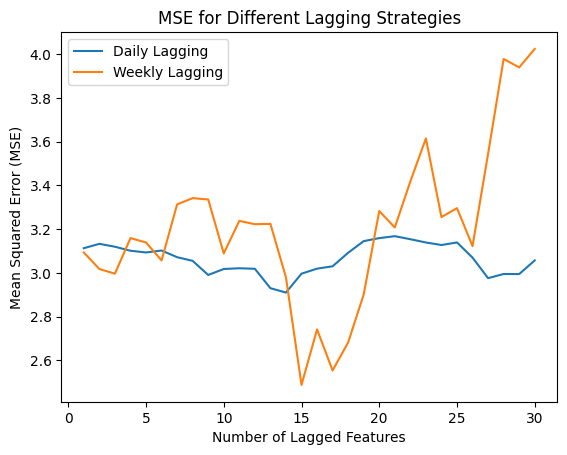

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

def create_lagged_features(df, lag_period):
    lagged_data = [df]
    for col in df.columns.drop('Date'):
        for i in range(1, lag_period + 1):
            lagged_data.append(df[col].shift(i).rename(f'{col}_lag_{i}'))
    df_lagged = pd.concat(lagged_data, axis=1)
    return df_lagged

def evaluate_model(df, lag_period, lag_freq='daily'):
    if lag_freq == 'daily':
        df_lagged = create_lagged_features(df, lag_period)
    elif lag_freq == 'weekly':
        df_lagged = create_lagged_features(df, lag_period * 5)
    else:
        raise ValueError("Invalid lag frequency")

    df_lagged = df_lagged.dropna()

    X = df_lagged.drop(['Date', 'Close'], axis=1)
    y = df_lagged['Close'].shift(-5).dropna()

    X = X.iloc[:-5]  # Align X and y
    X_train, X_test = X[:-50], X[-50:]
    y_train, y_test = y[:-50], y[-50:]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    return mse

# Experiment with different lag periods and frequencies
lag_periods = range(1, 31)
mse_daily = []
mse_weekly = []

for lag_period in lag_periods:
    mse_daily.append(evaluate_model(df.copy(), lag_period, lag_freq='daily'))
    mse_weekly.append(evaluate_model(df.copy(), lag_period, lag_freq='weekly'))

# Plot the results
plt.plot(lag_periods, mse_daily, label='Daily Lagging')
plt.plot(lag_periods, mse_weekly, label='Weekly Lagging')
plt.xlabel('Number of Lagged Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Different Lagging Strategies')
plt.legend()
plt.show()


## <a id='toc3_2_'></a>[Adding optimal (15x weekly) lag features](#toc0_)

In [15]:
def create_weekly_lagged_features(df, num_weeks):
    df_lagged = df.copy()
    lagged_data = [df]
    for col in df.columns.drop('Date'):
        for i in range(1, num_weeks + 1):
            df_lagged[f'{col}_lag_{i*5}'] = df[col].shift(i * 5)
            lagged_data.append(df[col].shift(i * 5).rename(f'{col}_lag_{i*5}'))
    df_lagged = pd.concat(lagged_data, axis=1)
    return df_lagged

# Add 15 weekly lagged features to the DataFrame
df = create_weekly_lagged_features(df, 15)

# Drop rows with NaN values due to lagging
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## <a id='toc3_3_'></a>[Encoding categorical data](#toc0_)

In [16]:
def encode_cyclical(a, max_value):
    x = (np.sin(2 * np.pi * a) + 1) / max_value
    y = (np.cos(2 * np.pi * a) + 1) / max_value
    return x, y

df['year'] = df['Date'].dt.year # This one is continious and numeric, must be scaled later
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_week'] = df['Date'].dt.day_of_week
df['day_of_year'] = df['Date'].dt.day_of_year
df['is_month_end'] = df['Date'].dt.is_month_end
df['is_leap_year'] = df['Date'].dt.is_leap_year

# These are numerical, cyclic encoding for them
df['month_sin'], df['month_cos'] = encode_cyclical(df['month'], 12)
df['day_sin'], df['day_cos'] = encode_cyclical(df['day'], 31)
df['day_of_week_sin'], df['day_of_week_cos'] = encode_cyclical(df['day_of_week'], 7)
df['day_of_year_sin'], df['day_of_year_cos'] = encode_cyclical(df['day_of_year'], 366)

# These ones are categorical, one hot for them
df = pd.get_dummies(df, columns=['is_month_end', 'is_leap_year']).astype(int)

 # kan kanskje flytte denne over til den seksjonen hvor man fjerner features og sånn
df = df.drop(columns=['Date', 'month', 'day', 'day_of_week', 'day_of_year'])

C:\Users\david\AppData\Local\Temp\ipykernel_14960\1201252671.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\david\AppData\Local\Temp\ipykernel_14960\1201252671.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\david\AppData\Local\Temp\ipykernel_14960\1201252671.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

## <a id='toc3_4_'></a>[Log-transforming skewed volume data](#toc0_)

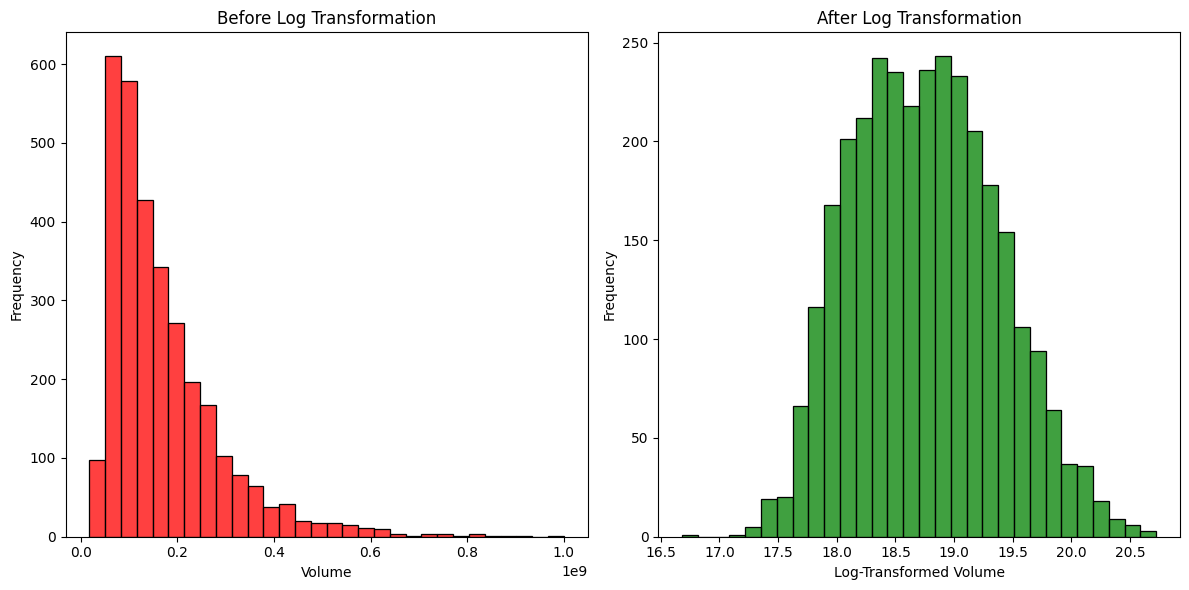

In [17]:
plt.figure(figsize=(12, 6))

# Plot before log transformation
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
sns.histplot(df['Volume'], bins=30, color='red')
plt.title('Before Log Transformation')
plt.xlabel('Volume')
plt.ylabel('Frequency')

# Apply log transformation
df['Volume'] = np.log1p(df['Volume'])  # log transformer den fordi den var skækk

# Plot after log transformation
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
sns.histplot(df['Volume'], bins=30, color='green')
plt.title('After Log Transformation')
plt.xlabel('Log-Transformed Volume')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## <a id='toc3_5_'></a>[Normalizing to scale numerical features](#toc0_)

In [18]:
features_to_scale = ['Open', 'Close', 'High', 'Low', 'Volume', 'year']
scaler = MinMaxScaler()
columns_to_scale = [col for col in df.columns if any(feature in col for feature in features_to_scale)]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head()

,Open,High,Low,Close,Volume,OpenInt,Open_lag_5,Open_lag_10,Open_lag_15,Open_lag_20,Open_lag_25,Open_lag_30,Open_lag_35,Open_lag_40,Open_lag_45,Open_lag_50,Open_lag_55,Open_lag_60,Open_lag_65,Open_lag_70,Open_lag_75,High_lag_5,High_lag_10,High_lag_15,High_lag_20,High_lag_25,High_lag_30,High_lag_35,High_lag_40,High_lag_45,High_lag_50,High_lag_55,High_lag_60,High_lag_65,High_lag_70,High_lag_75,Low_lag_5,Low_lag_10,Low_lag_15,Low_lag_20,Low_lag_25,Low_lag_30,Low_lag_35,Low_lag_40,Low_lag_45,Low_lag_50,Low_lag_55,Low_lag_60,Low_lag_65,Low_lag_70,Low_lag_75,Close_lag_5,Close_lag_10,Close_lag_15,Close_lag_20,Close_lag_25,Close_lag_30,Close_lag_35,Close_lag_40,Close_lag_45,Close_lag_50,Close_lag_55,Close_lag_60,Close_lag_65,Close_lag_70,Close_lag_75,Volume_lag_5,Volume_lag_10,Volume_lag_15,Volume_lag_20,Volume_lag_25,Volume_lag_30,Volume_lag_35,Volume_lag_40,Volume_lag_45,Volume_lag_50,Volume_lag_55,Volume_lag_60,Volume_lag_65,Volume_lag_70,Volume_lag_75,OpenInt_lag_5,OpenInt_lag_10,OpenInt_lag_15,OpenInt_lag_20,OpenInt_lag_25,OpenInt_lag_30,OpenInt_lag_35,OpenInt_lag_40,OpenInt_lag_45,OpenInt_lag_50,OpenInt_lag_55,OpenInt_lag_60,OpenInt_lag_65,OpenInt_lag_70,OpenInt_lag_75,year,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,is_month_end_False,is_month_end_True,is_leap_year_False,is_leap_year_True
0,0.23,0.23,0.23,0.23,0.20,0.00,0.23,0.23,0.22,0.21,0.22,0.22,0.21,0.21,0.24,0.23,0.23,0.24,0.25,0.25,0.24,0.23,0.22,0.22,0.21,0.22,0.21,0.22,0.21,0.23,0.22,0.22,0.24,0.25,0.25,0.25,0.23,0.23,0.23,0.21,0.22,0.22,0.22,0.22,0.23,0.23,0.23,0.23,0.24,0.26,0.25,0.23,0.23,0.23,0.21,0.22,0.22,0.22,0.21,0.23,0.23,0.23,0.24,0.24,0.25,0.25,0.06,0.03,0.04,0.04,0.03,0.05,0.04,0.10,0.04,0.07,0.04,0.05,0.05,0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1,0,1.00,0.00
1,0.23,0.23,0.23,0.23,0.31,0.00,0.23,0.23,0.23,0.21,0.22,0.22,0.22,0.22,0.23,0.23,0.23,0.24,0.24,0.25,0.25,0.23,0.23,0.22,0.22,0.22,0.21,0.22,0.21,0.23,0.23,0.22,0.23,0.24,0.25,0.24,0.23,0.23,0.23,0.22,0.22,0.22,0.22,0.22,0.23,0.23,0.23,0.23,0.24,0.26,0.25,0.23,0.23,0.23,0.22,0.22,0.22,0.21,0.22,0.24,0.23,0.22,0.23,0.25,0.25,0.25,0.04,0.06,0.04,0.05,0.07,0.08,0.07,0.06,0.08,0.04,0.07,0.05,0.02,0.03,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1,0,1.00,0.00
2,0.23,0.23,0.24,0.23,0.28,0.00,0.23,0.23,0.22,0.22,0.22,0.22,0.21,0.22,0.24,0.24,0.22,0.24,0.25,0.25,0.25,0.23,0.23,0.22,0.22,0.22,0.22,0.22,0.21,0.23,0.23,0.22,0.23,0.24,0.25,0.24,0.23,0.23,0.23,0.22,0.22,0.22,0.21,0.21,0.23,0.23,0.23,0.23,0.24,0.26,0.25,0.23,0.23,0.23,0.22,0.22,0.22,0.21,0.21,0.23,0.24,0.23,0.22,0.24,0.25,0.25,0.05,0.03,0.04,0.07,0.09,0.08,0.08,0.12,0.06,0.04,0.06,0.09,0.06,0.03,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1,0,1.00,0.00
3,0.23,0.23,0.23,0.23,0.31,0.00,0.23,0.23,0.23,0.22,0.22,0.23,0.21,0.22,0.23,0.24,0.23,0.22,0.24,0.25,0.25,0.23,0.23,0.22,0.23,0.22,0.22,0.21,0.22,0.22,0.23,0.23,0.22,0.24,0.25,0.25,0.23,0.23,0.23,0.23,0.22,0.22,0.21,0.22,0.22,0.24,0.23,0.23,0.24,0.25,0.25,0.23,0.23,0.23,0.22,0.22,0.22,0.21,0.22,0.22,0.24,0.23,0.22,0.24,0.25,0.25,0.02,0.05,0.03,0.06,0.09,0.10,0.07,0.08,0.10,0.04,0.06,0.07,0.07,0.07,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1,0,1.00,0.00
4,0.23,0.23,0.24,0.23,0.25,0.00,0.23,0.23,0.23,0.22,0.22,0.23,0.21,0.22,0.22,0.24,0.24,0.23,0.24,0.25,0.25,0.23,0.22,0.22,0.23,0.21,0.22,0.21,0.22,0.22,0.23,0.23,0.22,0.24,0.24,0.25,0.23,0.23,0.23,0.23,0.22,0.22,0.21,0.22,0.22,0.23,0.23,0.23,0.24,0.25,0.25,0.23,0.23,0.23,0.22,0.21,0.22,0.21,0.22,0.21,0.23,0.23,0.23,0.24,0.25,0.25,0.04,0.02,0.01,0.04,0.08,0.06,0.10,0.09,0.14,0.06,0.10,0.04,0.06,0.06,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1,0,1.00,0.00


# <a id='toc4_'></a>[Feature Extraction](#toc0_)

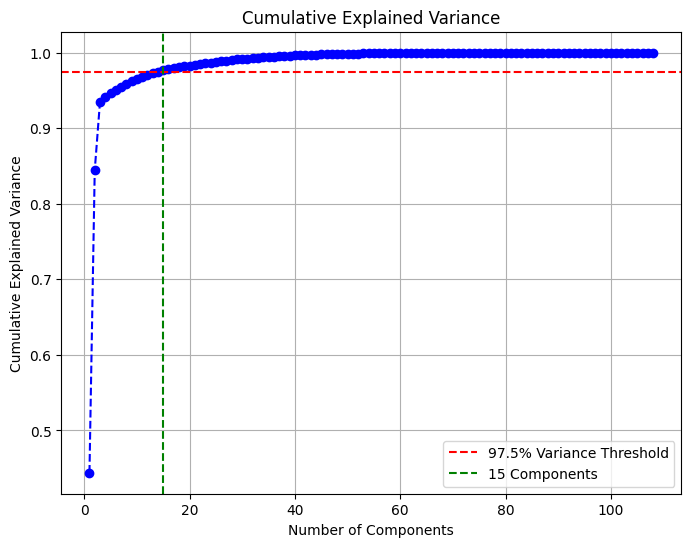

Selected 15 components based on 97.5% variance requirement.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Constants
REQUIRED_VARIANCE = 0.975
TARGET_VARIABLE = 'Close'  # Replace with your target variable name

# Assuming 'df' is your DataFrame
data = df.copy()

# Separate features and target variable
X = data.drop(TARGET_VARIABLE, axis=1)
y = data[TARGET_VARIABLE]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the PLS model
pls = PLSRegression(n_components=min(X_scaled.shape))  # Use the min of rows or columns for n_components

# Fit the PLS model
pls.fit(X_scaled, y)

# Transform the data using PLS components
X_transformed = pls.transform(X_scaled)

# Calculate explained variance
explained_variance = np.var(X_transformed, axis=0)
explained_variance_ratio = explained_variance / explained_variance.sum()
sorted_idx = np.argsort(explained_variance_ratio)[::-1]
explained_variance_ratio_sorted = explained_variance_ratio[sorted_idx]
cumulative_variance_sorted = np.cumsum(explained_variance_ratio_sorted)

# Find the number of components that meet the required variance threshold
n_components_required = np.argmax(cumulative_variance_sorted >= REQUIRED_VARIANCE) + 1

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_sorted) + 1), cumulative_variance_sorted, marker='o', linestyle='--', color='b')
plt.axhline(y=REQUIRED_VARIANCE, color='r', linestyle='--', label=f'{REQUIRED_VARIANCE*100}% Variance Threshold')
plt.axvline(x=n_components_required, color='g', linestyle='--', label=f'{n_components_required} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Select the required number of components
X_reduced = X_transformed[:, sorted_idx[:n_components_required]]
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])

# Step 3: Final feature set with target variable 'Close' as the first column
X_final = pd.concat([pd.Series(y, name='Close'), X_reduced_df], axis=1)

df = X_final

# Display the selected components and their variance
print(f"Selected {n_components_required} components based on {REQUIRED_VARIANCE*100}% variance requirement.")


# <a id='toc5_'></a>[Feature Selection](#toc0_)

## <a id='toc5_1_'></a>[Correlation Matrix](#toc0_)

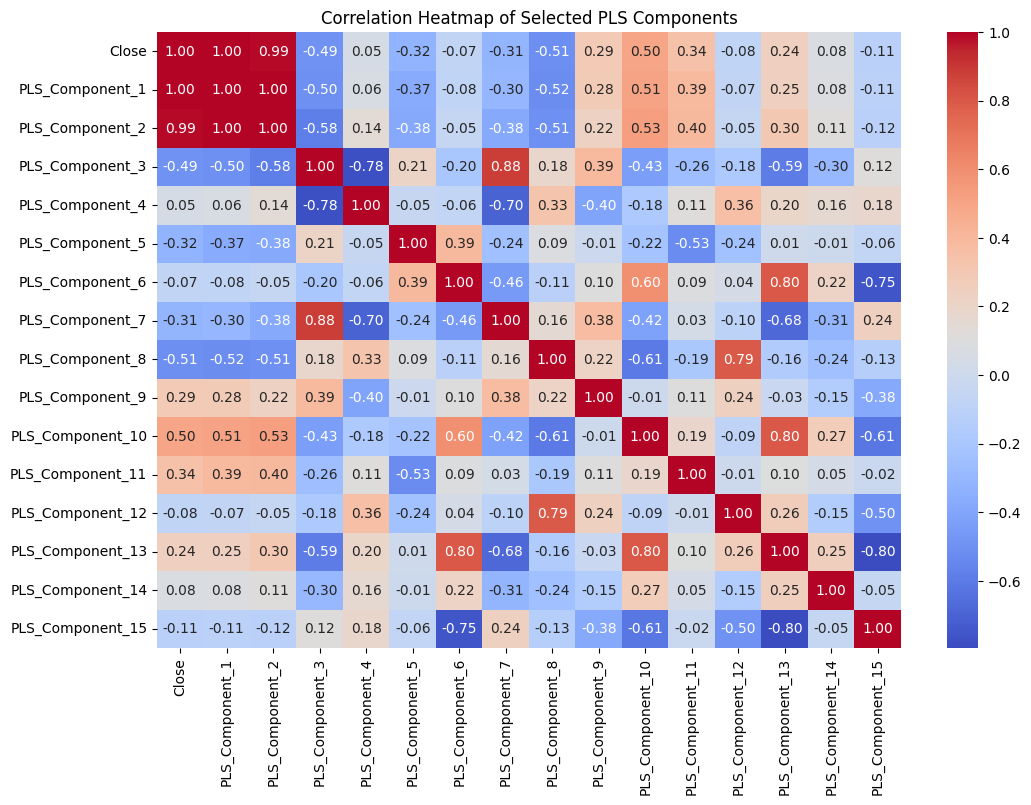

In [20]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected PLS Components')
plt.show()

## <a id='toc5_2_'></a>[Filter, wrapper, and embedded](#toc0_)

Optimal number of features (Filter Method): 14
Optimal number of features (Wrapper Method): 14
Optimal number of features (Embedded Method - Lasso): 15
Best Method: Wrapper
Optimal Number of Features: 14
Selected Features: ['PLS_Component_1', 'PLS_Component_2', 'PLS_Component_3', 'PLS_Component_4', 'PLS_Component_5', 'PLS_Component_6', 'PLS_Component_7', 'PLS_Component_8', 'PLS_Component_9', 'PLS_Component_10', 'PLS_Component_11', 'PLS_Component_12', 'PLS_Component_14', 'PLS_Component_15']


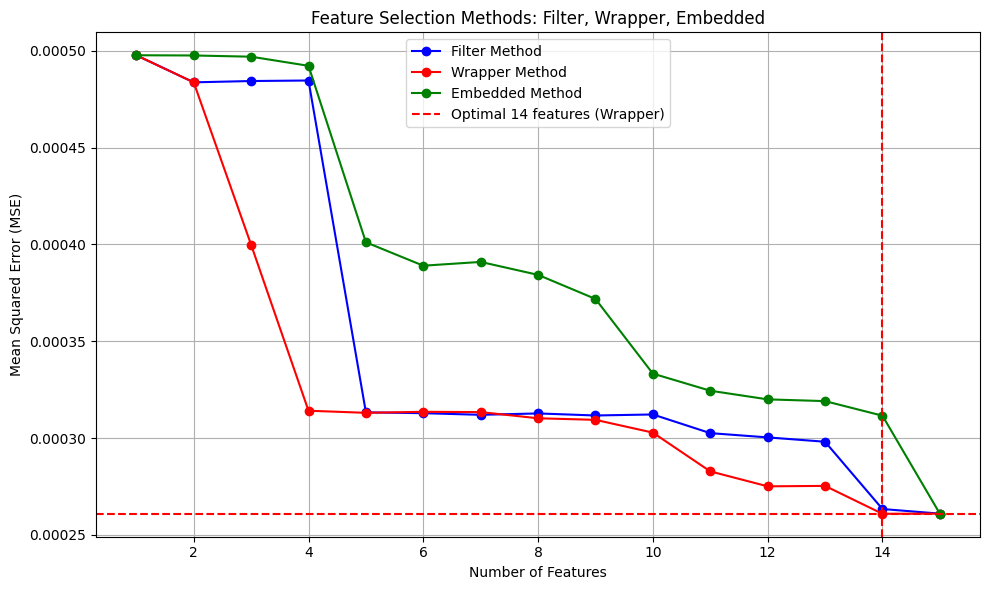

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ------------------- Constants -------------------
LAMBDA_PARAM = 0.000005  # Penalty term to balance MSE vs. Number of Features

X = df.drop(columns=['Close'])
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
model = LinearRegression()

# ------------------- Filter Method (ANOVA F-test) -------------------
num_features_list_filter = []
mse_filter_list = []

# Evaluate different numbers of features using ANOVA F-test
for num_features in range(1, X.shape[1] + 1):
    filter_selector = SelectKBest(score_func=f_regression, k=num_features)
    X_train_selected = filter_selector.fit_transform(X_train, y_train)
    X_test_selected = filter_selector.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_filter.append(num_features)
    mse_filter_list.append(mse)

# Calculate tradeoff score
tradeoff_filter_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_filter_list, num_features_list_filter)]

optimal_index_filter = np.argmin(tradeoff_filter_list)
optimal_num_features_filter = num_features_list_filter[optimal_index_filter]
optimal_mse_filter = mse_filter_list[optimal_index_filter]
print(f"Optimal number of features (Filter Method): {optimal_num_features_filter}")

# ------------------- Wrapper Method (RFE) -------------------
num_features_list_wrapper = []
mse_wrapper_list = []

# Evaluate different numbers of features using RFE
for num_features in range(1, X.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_wrapper.append(num_features)
    mse_wrapper_list.append(mse)

# Calculate tradeoff score
tradeoff_wrapper_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_wrapper_list, num_features_list_wrapper)]

optimal_index_wrapper = np.argmin(tradeoff_wrapper_list)
optimal_num_features_wrapper = num_features_list_wrapper[optimal_index_wrapper]
optimal_mse_wrapper = mse_wrapper_list[optimal_index_wrapper]
print(f"Optimal number of features (Wrapper Method): {optimal_num_features_wrapper}")

# ------------------- Embedded Method (Lasso) -------------------
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
importance = np.abs(lasso.coef_)
top_features_idx = np.argsort(importance)[::-1]

num_features_list_embedded = []
mse_embedded_list = []

for i in range(1, len(top_features_idx) + 1):
    X_train_selected = X_train.iloc[:, top_features_idx[:i]]
    X_test_selected = X_test.iloc[:, top_features_idx[:i]]
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_embedded.append(i)
    mse_embedded_list.append(mse)

# Calculate tradeoff score
tradeoff_embedded_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_embedded_list, num_features_list_embedded)]

optimal_index_embedded = np.argmin(tradeoff_embedded_list)
optimal_num_features_embedded = num_features_list_embedded[optimal_index_embedded]
optimal_mse_embedded = mse_embedded_list[optimal_index_embedded]
print(f"Optimal number of features (Embedded Method - Lasso): {optimal_num_features_embedded}")

# ------------------- Find Best Method -------------------
# Find the best method based on the optimal MSE
best_method = None
best_optimal_num_features = None
best_optimal_mse = float('inf')

# Check Filter Method
if optimal_mse_filter < best_optimal_mse:
    best_method = 'Filter'
    best_optimal_num_features = optimal_num_features_filter
    best_optimal_mse = optimal_mse_filter

# Check Wrapper Method
if optimal_mse_wrapper < best_optimal_mse:
    best_method = 'Wrapper'
    best_optimal_num_features = optimal_num_features_wrapper
    best_optimal_mse = optimal_mse_wrapper

# Check Embedded Method
if optimal_mse_embedded < best_optimal_mse:
    best_method = 'Embedded'
    best_optimal_num_features = optimal_num_features_embedded
    best_optimal_mse = optimal_mse_embedded

# ------------------- Select the Best Features -------------------
# Now, let's select the features based on the best method

if best_method == 'Filter':
    # Filter Method: Get the top features selected by ANOVA F-test
    filter_selector = SelectKBest(score_func=f_regression, k=best_optimal_num_features)
    X_selected = filter_selector.fit_transform(X, y)
    selected_columns = X.columns[filter_selector.get_support()]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Wrapper':
    # Wrapper Method: Get the top features selected by RFE
    rfe = RFE(estimator=model, n_features_to_select=best_optimal_num_features)
    rfe.fit(X, y)
    selected_columns = X.columns[rfe.support_]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Embedded':
    # Embedded Method: Get the top features selected by Lasso
    top_features_idx = np.argsort(np.abs(lasso.coef_))[::-1][:best_optimal_num_features]
    selected_columns = X.columns[top_features_idx]
    df_selected = df[['Close'] + selected_columns.tolist()]

print(f"Best Method: {best_method}")
print(f"Optimal Number of Features: {best_optimal_num_features}")
print(f"Selected Features: {selected_columns.tolist()}")

# ------------------- Plotting -------------------
# Plot all methods on the same graph
plt.figure(figsize=(10, 6))

# Plot for Filter Method (ANOVA F-test)
plt.plot(num_features_list_filter, mse_filter_list, marker='o', linestyle='-', color='b', label='Filter Method')

# Plot for Wrapper Method (RFE)
plt.plot(num_features_list_wrapper, mse_wrapper_list, marker='o', linestyle='-', color='r', label='Wrapper Method')

# Plot for Embedded Method (Lasso)
plt.plot(num_features_list_embedded, mse_embedded_list, marker='o', linestyle='-', color='g', label='Embedded Method')

# Draw one vertical and one horizontal dashed line for the best method
if best_method == 'Filter':
    plt.axvline(x=best_optimal_num_features, color='b', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Filter)')
    plt.axhline(y=best_optimal_mse, color='b', linestyle='--')
elif best_method == 'Wrapper':
    plt.axvline(x=best_optimal_num_features, color='r', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Wrapper)')
    plt.axhline(y=best_optimal_mse, color='r', linestyle='--')
else:
    plt.axvline(x=best_optimal_num_features, color='g', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Embedded)')
    plt.axhline(y=best_optimal_mse, color='g', linestyle='--')

# Labeling the plot
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Feature Selection Methods: Filter, Wrapper, Embedded')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## <a id='toc5_3_'></a>[Interpretation and integration into the df](#toc0_)

Chat sin forklaring på hvordan optimal metode og antall features er valgt:
The best method and optimal number of features are selected by evaluating each feature selection method (Filter, Wrapper, and Embedded) based on their Mean Squared Error (MSE) and a tradeoff score that includes a penalty for the number of features. The tradeoff score is calculated as the sum of the MSE and a penalty term (λ * number of features). The method and number of features that minimize this tradeoff score are deemed the best. The plot visually highlights the optimal number of features and the corresponding MSE for the best method using vertical and horizontal dashed lines.

In [22]:
df_prev = df.copy()
df = df_selected

## <a id='toc5_4_'></a>[Correlation matrix before/after feature selection](#toc0_)
begrunner med at vi har brukt wrapper som metode for å selecte features, dermed har de featurene som sammen ga best prediksjon i en simpel modell blitt valgt ut, og selv om en del av de featurene med lavest correlation med Close er fjernet, så er det ikke en selvfølge at det er akkuratt de som forsvinner

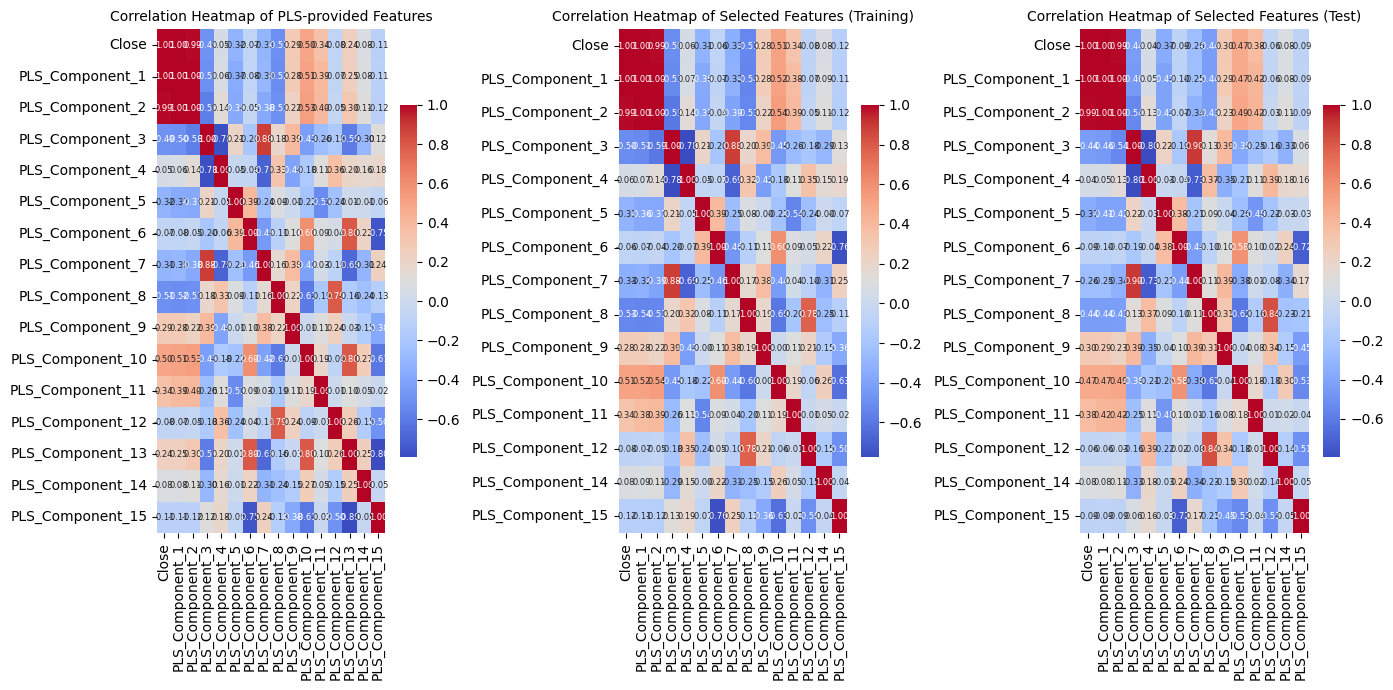

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the selected feature dataset (df_selected) into training and test sets (80/20)
X_train, X_test = train_test_split(df_selected, test_size=0.2, random_state=42)

# Calculate the correlation matrices for both the original and selected training data
corr_original = corr  # Correlation matrix of the original features (assumes 'corr' is already computed)
corr_selected_train = (
    X_train.corr()
)  # Correlation matrix of the selected features in training set
corr_selected_test = (
    X_test.corr()
)  # Correlation matrix of the selected features in test set

# Plot the correlation heatmap with smaller cells and text
plt.figure(figsize=(14, 7))  # Increase figure width for more room

# Heatmap for original features
plt.subplot(1, 3, 1)
sns.heatmap(
    corr_original,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 6},  # Smaller text
    cbar_kws={"shrink": 0.7},
)  # Smaller color bar
plt.title("Correlation Heatmap of PLS-provided Features", fontsize=10)

# Heatmap for selected features in training set
plt.subplot(1, 3, 2)
sns.heatmap(
    corr_selected_train,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 6},  # Smaller text
    cbar_kws={"shrink": 0.7},
)  # Smaller color bar
plt.title("Correlation Heatmap of Selected Features (Training)", fontsize=10)

# Heatmap for selected features in test set
plt.subplot(1, 3, 3)
sns.heatmap(
    corr_selected_test,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 6},  # Smaller text
    cbar_kws={"shrink": 0.7},
)  # Smaller color bar
plt.title("Correlation Heatmap of Selected Features (Test)", fontsize=10)

plt.tight_layout()
plt.show()
corr_selected_train.to_csv("training.csv", index=False)

# <a id='toc6_'></a>[Ferdig med feature extraction og selection!](#toc0_)
Prosessen med extraction skapte nye features på en måte som minner om PCA, men som skal være passende for supervised learning og time series (PCA er visst IKKE ment for hverken supervised eller time series, så måtte bringe frem tyngre skyts, som var pain å implemenentere). Etter at extraction hadde gjort om de originale featurene til features i et nytt domene, ble selection brukt for å finne ut hvilke av de nye featurene som gir mest "bang for buck" i prediksjon av Close-featuren. Har et plott rett over her som viser dette for 3 ulike metoder for selection. Deretter ble de featurene som ble definert som best valgt ut, og det er disse som er i dataframen nå (sammen med Close). Basically: dataframen har "Close", og PLS_component_{i}, for litt ulike verdier av i. 